# Day 14: Monte Carlo, Continued

---

- Monte Carlo concepts
  - Varying deterministic variables with `df_det`
  - Estimating distributions
  - Random seeds / common random numbers
    - Important for optimization; helps ensure smoothness
- Estimating probabilities
  - Random variable as indicator


In [1]:
import pandas as pd 
import grama as gr 
import numpy as np

from plotnine import *

DF = gr.Intention()


## Monte Carlo on Grama Models

---

As a running example, let's look at the cantilever beam model. There's a fair bit going on in this model, so the primary thing I want you to concentrate on are the *limit state functions* `g_disp` and `g_stress`. These are functions where 

$$g > 0\text{ corresponds to success}$$
$$g \leq 0\text{ corresponds to failure}$$

The beam limit states are

$$g_{\text{disp}} = \delta_{\max} - \delta_{tip}$$
$$g_{\text{stress}} = \sigma_{\max} - \sigma_{\text{applied}}$$


In [2]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()

md_beam.printpretty()


model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
    copula:
        Independence copula
  functions:
    cross-sectional area: ['w', 't'] -> ['c_area']
    limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
    limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']


### Uncertainty Propagation

Note that if the inputs $X \in \mathbb{R}^d$ are *random* $X \sim \rho$, then any function of those random inputs is itself random $F = f(X) \sim \psi$. As we saw last time, the distribution for $F \sim \psi$ can we weird and complicated.

> Random inputs are said to *induce* randomness on outputs

Calling`gr.ev_monte_carlo()` on a Grama model draws random values for the `inputs` and computes values for each `output`.


In [11]:
(
    md_beam
    >> gr.ev_monte_carlo(n=4, df_det="nom")
)

,E,H,Y,V,w,t,g_disp,g_stress,c_area
0,2.791609e+07,566.776890,37117.860172,994.964227,3.0,3.0,0.227902,0.060313,9.0
1,2.816919e+07,580.515935,42092.276141,1037.926039,3.0,3.0,0.168675,0.153172,9.0
2,2.910555e+07,371.005092,39706.584285,950.860492,3.0,3.0,0.521742,0.258295,9.0
3,2.955490e+07,495.369165,42405.767112,991.980018,3.0,3.0,0.400844,0.233839,9.0


### Estimating distributions

We talked about Monte Carlo as a way to approximate the mean of a random variable:


In [4]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.tf_summarize(
        g_disp_mean=gr.mean(DF.g_disp),
        g_stress_mean=gr.mean(DF.g_stress),
    )
)

eval_monte_carlo() is rounding n...


,g_disp_mean,g_stress_mean
0,0.329613,0.163079


These mean values are greater than zero, which is a positive indication. We want $g > 0$, so *on average* the structure seems safe. But remember that the mean is only a typical value; what if we want a beam that isn't just "typically" safe?

However, sometimes we want more than just the mean; calling `gr.plot_auto()` on the output of `gr.eval_monte_carlo()` will automatically plot a histogram for each output:


eval_monte_carlo() is rounding n...
Calling plot_hists....


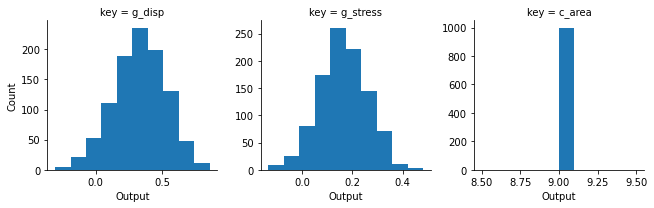

In [3]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.pt_auto()
)

Remember that:

$$g > 0\text{ corresponds to success}$$
$$g \leq 0\text{ corresponds to failure}$$

Now we can see that a small fraction of the distributions for `g_disp` and `g_stress` lie below zero; this indicates a small---but nonzero---probability of failure.


### Sweeping deterministic values

Let's take another look at the `printpretty()` output of `md_beam`; note that it has both deterministic and random variables:

In [5]:
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
    copula:
        Independence copula
  functions:
    cross-sectional area: ['w', 't'] -> ['c_area']
    limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
    limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']


Note that the beam model has both *deterministic* and *random* variables:

| Input | Type | Meaning |
|---|---|---|
| `w` | Deterministic | Design variable: Width |
| `t` | Deterministic | Design variable: Thickness |
| `H` | Random | Uncertainty: Horizontal tip load |
| `V` | Random | Uncertainty: Vertical tip load |
| `E` | Random | Uncertainty: Material elasticity |
| `Y` | Random | Uncertainty: Material (yield) strength |

What happens to the deterministic variables `w, t` when we set `df_det="nom"`?


In [11]:
(
    md_beam
    >> gr.ev_monte_carlo(n=4, df_det="nom")
)

,E,H,Y,V,w,t,g_disp,g_stress,c_area
0,2.791609e+07,566.776890,37117.860172,994.964227,3.0,3.0,0.227902,0.060313,9.0
1,2.816919e+07,580.515935,42092.276141,1037.926039,3.0,3.0,0.168675,0.153172,9.0
2,2.910555e+07,371.005092,39706.584285,950.860492,3.0,3.0,0.521742,0.258295,9.0
3,2.955490e+07,495.369165,42405.767112,991.980018,3.0,3.0,0.400844,0.233839,9.0


Note that `w, t` take single, fixed values. Setting `df_det="nom"` sets *nominal* values for all the deterministic inputs. Note that if you want to set specific values for the deterministic variables, you can set `df_det` to a DataFrame of desired values.

The helper `gr.df_make()` is a convenient way to make a DataFrame; in particular, you can hold one or more values constant and sweep one value. For instance, the line

> `gr.df_make(w=3.0, t=np.linspace(2, 4))`

will set `w == 3.0` and sweep over values of `t`.


In [10]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=1e2,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4)),
    )
    
    ## Summarize
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
)


eval_monte_carlo() is rounding n...


,g_stress_mean,g_stress_sd
0,0.073542,0.340134


We swept over values of $t$, so why doesn't $t$ show up in these results?

<br><br><br>

In order to avoid summarizing over the different samples for different values of $t$, we need to `gr.tf_group_by(DF.t)` to compute each mean/sd within a *group* defined by unique values of $t$.


In [71]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=1e2,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4, num=6)),
    )
    
    ## Summarize at each value of t
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
)

eval_monte_carlo() is rounding n...


,t,g_stress_mean,g_stress_sd
0,2.0,-0.665890,0.162642
1,2.4,-0.215537,0.124480
2,2.8,0.063824,0.102198
3,3.2,0.250202,0.088304
4,3.6,0.381448,0.079199
5,4.0,0.477804,0.072991


Using a `gr.tf_group_by()` before the summary provides a mean and standard deviation at each value of `t`, which we can plot:


eval_monte_carlo() is rounding n...


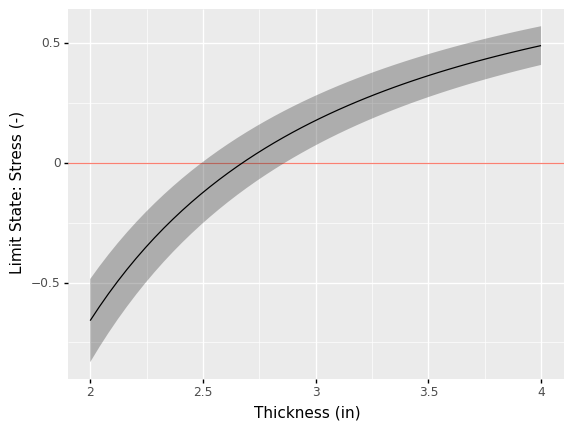

<ggplot: (8768863520133)>

In [9]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=1e2,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4)),
    )
    
    ## Summarize at each value of t
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
    
    >> ggplot(aes("t"))
    + geom_hline(yintercept=0, color="salmon")
    + geom_ribbon(aes(ymin="g_stress_mean - g_stress_sd", ymax="g_stress_mean + g_stress_sd"), alpha=1/3)
    + geom_line(aes(y="g_stress_mean"))
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)"
    )
)

### Random seeds

One of the key arguments to `gr.eval_monte_carlo()` is `seed`; this sets the [random seed](https://en.wikipedia.org/wiki/Random_seed) for [pseudorandom](https://en.wikipedia.org/wiki/Pseudorandomness) number generation. Setting a fixed seed will "fix" the values generated by `gr.eval_monte_carlo()`. This raises all kinds of questions about "what is random?" that we won't get into in this class....

*Aside*: Before the advent of modern computing and access to high-quality pseudorandom number generators, scientists would use dice, wheels, and [published tables of randomly-generated digits](https://en.wikipedia.org/wiki/A_Million_Random_Digits_with_100,000_Normal_Deviates).  This has led to some humorous [Amazon reviews](https://www.amazon.com/product-reviews/0833030477/). There is, *astoundingly*, an [audiobook](http://amillionrandomdigits.com/index.html) version of this work as well.


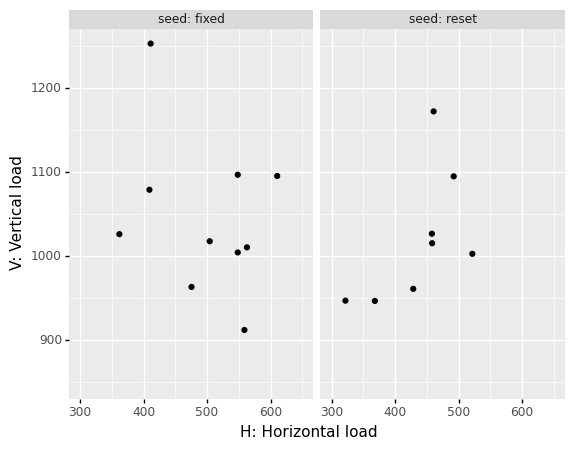

<ggplot: (8768858903459)>

In [56]:
# Reset the seed for this demo
np.random.seed()

# Note the difference between these two lines....
df_sample_rand = gr.eval_monte_carlo(md_beam, n=10, df_det="nom")
df_sample_fixed = gr.eval_monte_carlo(md_beam, n=10, df_det="nom", seed=101)

# Visualize both samples
(
    df_sample_rand
    >> gr.tf_mutate(source="seed: reset")
    >> gr.tf_bind_rows(
        df_sample_fixed
        >> gr.tf_mutate(source="seed: fixed")
    )
    
    >> ggplot(aes("H", "V"))
    + geom_point()
    
    + coord_cartesian(
        xlim=(300, 650),
        ylim=(850, 1250),
    )
    + facet_wrap("source")
    + labs(x="H: Horizontal load", y="V: Vertical load")
)


Note that with a fixed seed the random numbers don't change. Setting the seed gives us a fixed sample. Here's a rough rule-of-thumb on setting seeds:

> - When testing the statistical properties of a random algorithm, it's important to test a variety of seeds.
> - When using a random algorithm to do design, it's best to fix a single seed.

Fixing a random seed allows us to generate *common random numbers*.


### Common random numbers

Remember how we did a sweep over `t` with the beam model? The response looks smooth. That's because `gr.eval_monte_carlo()` uses a single sample (set of realizations) for each setting of the deterministic variables. If we plot each realization over $t$ grouped by the realization of the random inputs, we'll see a set of smooth curves:


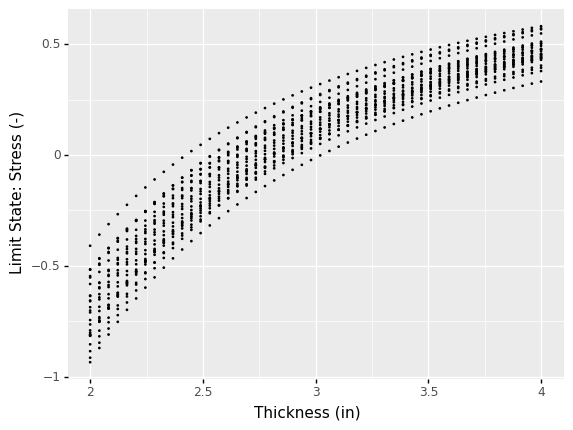

<ggplot: (8768859174054)>

In [65]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=25,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4)),
    )
    
    ## Visualize each realization; we get smooth sweeps across `t`
    >> ggplot(aes("t", "g_stress"))
    + geom_point(aes(group="E"), size=0.1)
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)"
    )
)

If we *instead* draw an independent sample for each value of $t$, we will no longer see a "smooth" response:


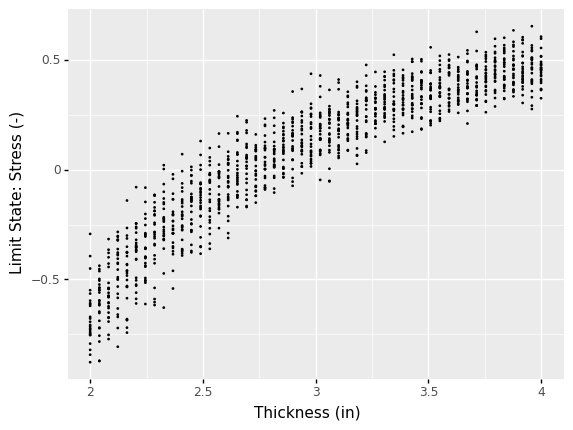

<ggplot: (8768864148592)>

In [64]:
## Purposefully draw an independent sample for each t value
df_sweep_t = gr.df_make(w=3.0, t=np.linspace(2, 4))
df_sweep = pd.DataFrame()

for i in range(df_sweep_t.shape[0]):
    df_tmp = (
        md_beam
        >> gr.ev_monte_carlo(
            n=25,
            df_det=df_sweep_t.iloc[[i]],
            # seed=101, # Set seed for common random numbers
        )
    )
    
    df_sweep = pd.concat((df_tmp, df_sweep), axis=0)
    
(
    df_sweep
    >> ggplot(aes("t", "g_stress"))
    + geom_point(aes(group="E"), size=0.1)
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)"
    )
)

Where this really matters is in using these results to do *optimization*; imagine we aim to find the point in `t` where the mean of `g_stress` crosses zero. The following curve shows us that using independent samples will give us a jagged curve, which will in turn make optimization using this result challenging:


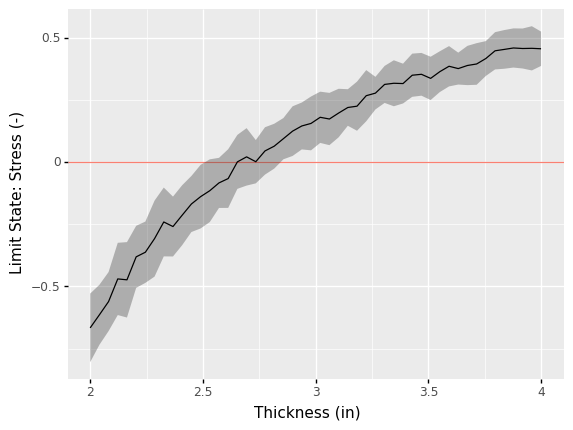

<ggplot: (8768863568276)>

In [66]:
(
    df_sweep
    ## Summarize at each value of t
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
    
    >> ggplot(aes("t"))
    + geom_hline(yintercept=0, color="salmon")
    + geom_ribbon(aes(ymin="g_stress_mean - g_stress_sd", ymax="g_stress_mean + g_stress_sd"), alpha=1/3)
    + geom_line(aes(y="g_stress_mean"))
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)",
        title="Method: Independent Samples"
    )
)


The *one simple change* you can make to deal with this is give an integer value for `seed` when calling `gr.eval_monte_carlo()`. This will give you *common random numbers* across different values of the deterministic variables.


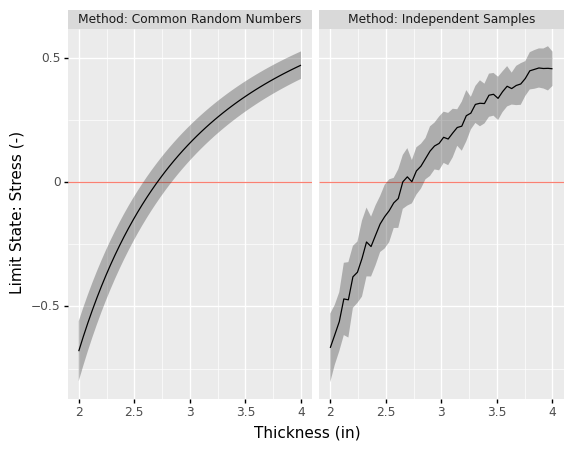

<ggplot: (8768856914436)>

In [69]:
## Purposefully draw an independent sample for each t value
df_sweep_t = gr.df_make(w=3.0, t=np.linspace(2, 4))
df_sweep_com = pd.DataFrame()

for i in range(df_sweep_t.shape[0]):
    df_tmp = (
        md_beam
        >> gr.ev_monte_carlo(
            n=25,
            df_det=df_sweep_t.iloc[[i]],
            seed=101, # Set seed for common random numbers
        )
    )
    
    df_sweep_com = pd.concat((df_tmp, df_sweep_com), axis=0)
    
## Visualize
(
    # Summarize the data
    df_sweep_com
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
    >> gr.tf_mutate(method="Method: Common Random Numbers")
    
    # Bind previous results for comparison
    >> gr.tf_bind_rows(
        df_sweep
        >> gr.tf_group_by(DF.t)
        >> gr.tf_summarize(
            g_stress_mean=gr.mean(DF.g_stress),
            g_stress_sd=gr.sd(DF.g_stress),
        )
        >> gr.tf_mutate(method="Method: Independent Samples")
    )
    
    # Make the visual
    >> ggplot(aes("t"))
    + geom_hline(yintercept=0, color="salmon")
    + geom_ribbon(aes(ymin="g_stress_mean - g_stress_sd", ymax="g_stress_mean + g_stress_sd"), alpha=1/3)
    + geom_line(aes(y="g_stress_mean"))
    
    + facet_wrap("method")
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)",
    )
)

## Estimating Probabilities

---
